In [1]:
use_gpu = True
data_dir = '/home/victor/data'

In [2]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 1
%aimport alphagan

In [3]:
from collections import defaultdict
from psutil import cpu_count

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.nn import init, Parameter
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
cifar = datasets.CIFAR10(
    data_dir,
    train=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ]),
    target_transform=None,
    download=True)
cifar = torch.stack(list(zip(*cifar))[0])*2-1
cifar.size()

Files already downloaded and verified


torch.Size([50000, 3, 32, 32])

In [5]:
cifar_test = datasets.CIFAR10(
    data_dir,
    train=False,
    transform=transforms.Compose([
        transforms.ToTensor()
    ]),
    target_transform=None,
    download=False)
cifar_test = torch.stack(list(zip(*cifar_test))[0])*2-1
cifar_test.size()                          

torch.Size([10000, 3, 32, 32])

In [321]:
batch_size = 64

In [322]:
n_train, n_test = len(cifar)//1, batch_size*64

num_workers = cpu_count() if use_gpu else 0

train_idxs = torch.LongTensor(np.random.permutation(len(cifar))[:n_train])
X_train = DataLoader(cifar[train_idxs], batch_size=batch_size, shuffle=True,
                     num_workers=num_workers, pin_memory=use_gpu)
test_idxs = torch.LongTensor(np.random.permutation(len(cifar_test))[:n_test])
X_test = DataLoader(cifar_test[test_idxs], batch_size=batch_size, shuffle=False,
                   num_workers=num_workers, pin_memory=use_gpu)

In [719]:
class ChannelsToLinear(nn.Linear):
    """Flatten a Variable to 2d and apply Linear layer"""
    def forward(self, x):
        b = x.size(0)
        return super().forward(x.view(b,-1))

class LinearToChannels2d(nn.Linear):
    """Reshape 2d Variable to 4d after Linear layer"""
    def __init__(self, m, n, w=1, h=None, **kw):
        h = h or w
        super().__init__(m, n*w*h, **kw)
        self.w = w
        self.h = h
    def forward(self, x):
        b = x.size(0)
        return super().forward(x).view(b, -1, self.w, self.h)

class ResBlock(nn.Module):
    """Versatile ResNet block which can be upsampling or downsampling"""
    def __init__(self, c,
                 activation=nn.LeakyReLU, norm=nn.BatchNorm2d,
                 upsample=1, downsample=1, init_gain=1, groups=1):
        super().__init__()
        self.a1 = activation()
        self.a2 = activation()
        self.norm1 = norm and norm(c)
        self.norm2 = norm and norm(c)
        
        to_init = []
        self.resample=None
        assert upsample==1 or downsample==1
        if upsample>1:
            self.conv1 = nn.Sequential(
                nn.Conv2d(c, upsample**2*c, 3, 1, 1, bias=False, groups=groups),
                nn.PixelShuffle(upsample)
            )
            to_init.append(self.conv1[0].weight)
            # upsample residual
            self.resample = nn.UpsamplingNearest2d(scale_factor=upsample)
        else:
            self.conv1 = nn.Conv2d(
                c, c, 3, 1, 1, bias=False, groups=groups)
            to_init.append(self.conv1.weight)
            
        if downsample>1:
            # downsample residual
            self.conv1 = nn.Sequential(self.conv1, nn.AvgPool2d(downsample))
            self.resample = nn.AvgPool2d(downsample)
            
        self.conv2 = nn.Conv2d(
            c, c, 3, 1, 1, bias=False, groups=groups)
        to_init.append(self.conv2.weight)
        
        # if using grouping, add a 1x1 convolution to each conv layer
        if groups!=1:
            self.conv1 = nn.Sequential(
                self.conv1, nn.Conv2d(c,c,1,bias=False))
            self.conv2 = nn.Sequential(
                self.conv2, nn.Conv2d(c,c,1,bias=False))
            to_init.extend([self.conv1[1].weight, self.conv2[1].weight])
                    
        # init
        for w in to_init:
            init.xavier_normal(w, init_gain)
        
    def forward(self, x):
        y = self.conv1(x)
        if self.norm1:
            y = self.norm1(y)
        y = self.a1(y)
        
        y = self.conv2(y)
        if self.norm2:
            y = self.norm2(y)
        
        if self.resample:
            x = self.resample(x)
        
        return self.a2(x+y)

In [720]:
latent_dim = 128

In [721]:
h = 128
pool = nn.AvgPool2d
norm = nn.BatchNorm2d#None

a, g = nn.ReLU, init.calculate_gain('relu')
groups = 1#h//8
E = nn.Sequential(
    nn.Conv2d(3,h,3,1,1,bias=False), pool(2), a(),
    ResBlock(h, activation=a, norm=norm, init_gain=g, groups=groups, downsample=2),
    ResBlock(h, activation=a, norm=norm, init_gain=g, groups=groups, downsample=2),
    ResBlock(h, activation=a, norm=norm, init_gain=g, groups=groups),
    ChannelsToLinear(h*16, latent_dim)
)
for layer in (E[0], E[6]):
    init.xavier_normal(layer.weight, g)

t = Variable(torch.randn(batch_size,3,32,32))
assert E(t).size() == (batch_size,latent_dim)

In [722]:
h = 128
norm = nn.BatchNorm2d#None
a, g = nn.ReLU, init.calculate_gain('relu')
groups = 1#h//8
G = nn.Sequential(
    LinearToChannels2d(latent_dim,h,4,4, bias=False), a(),
    ResBlock(h, activation=a, norm=norm, init_gain=g, groups=groups, upsample=2),
    ResBlock(h, activation=a, norm=norm, init_gain=g, groups=groups, upsample=2),
    ResBlock(h, activation=a, norm=norm, init_gain=g, groups=groups, upsample=2),
    nn.Conv2d(h, 3, 1, 1), nn.Tanh()
)
for layer in (G[0], G[5]):
    init.xavier_normal(layer.weight, 2)

t = Variable(torch.randn(batch_size,latent_dim))
assert G(t).size() == (batch_size,3,32,32)

/home/victor/.conda/envs/torch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:135: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")


In [723]:
h = 128
pool = nn.AvgPool2d
norm = nn.BatchNorm2d
a, g = lambda: nn.LeakyReLU(.2), init.calculate_gain('leaky_relu', .2)
groups = 1

D = nn.Sequential(
    nn.Conv2d(3,h,5,2,2, bias=False), a(),
    ResBlock(h, activation=a, norm=norm, init_gain=g, groups=groups, downsample=2),
    ResBlock(h, activation=a, norm=norm, init_gain=g, groups=groups, downsample=2),
    ResBlock(h, activation=a, norm=norm, init_gain=g, groups=groups),
    ChannelsToLinear(h*16, 1), nn.Sigmoid()
)
for layer in (D[0], D[5]):
    init.xavier_normal(layer.weight, g)
    
t = Variable(torch.randn(batch_size,3,32,32))
assert D(t).size() == (batch_size,1)

In [724]:
# no batch norm in the code discriminator, it causes trouble
h = 700
a, g = lambda: nn.LeakyReLU(.2), init.calculate_gain('leaky_relu', .2)
C = nn.Sequential(
    nn.Linear(latent_dim, h), a(),
    nn.Linear(h, h), a(),
    nn.Linear(h, 1), nn.Sigmoid(),
)

for i,layer in enumerate(C):
    if i%2==0:
        init.xavier_normal(layer.weight, g)

t = Variable(torch.randn(batch_size,latent_dim))
assert C(t).size() == (batch_size,1)

In [725]:
model = alphagan.AlphaGAN(E, G, D, C, latent_dim, lambd=4)
if use_gpu:
    model = model.cuda()

In [726]:
# model.load_state_dict(torch.load('../modelas/cifar10_dim_128_lambda_4_epochs_4.torch'))

In [727]:
diag = []
def log_fn(d):
    d = pd.DataFrame(d)
    diag.append(d)
    print(d)
def checkpoint_fn(model, epoch):
    path =  '../models/cifar10_dim_{}_lambda_{}_epochs_{}.torch'.format(
        model.latent_dim, model.lambd, epoch
    )
    torch.save(model.state_dict(), path)

In [ ]:
model.fit(
    X_train, X_test,
    n_iter=(2,1,1), n_epochs=4,
    log_fn=log_fn, log_every=1,
    checkpoint_fn=checkpoint_fn, checkpoint_every=4
)

/home/victor/.conda/envs/torch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:135: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")


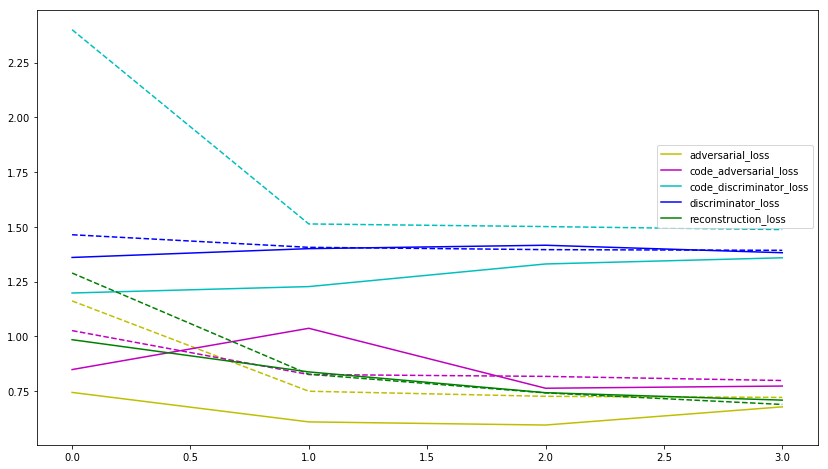

In [735]:
fig, ax = plt.subplots(1,1,figsize=(14,8))
diagnostic = pd.concat([pd.DataFrame(d.stack(), columns=[i]).T for i,d in enumerate(diag)])
cols = list('rgbcmy')
colors = defaultdict(lambda: cols.pop())
for c in diagnostic:
    component, dataset = c
    kw = {}
    if dataset=='valid':
        kw['label'] = component
    else:
        kw['ls'] = '--'
    ax.plot(diagnostic[c].values, c=colors[component], **kw)
ax.legend(bbox_to_anchor=(1, 0.7))

In [736]:
model.eval()
pass

/home/victor/.conda/envs/torch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:135: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")


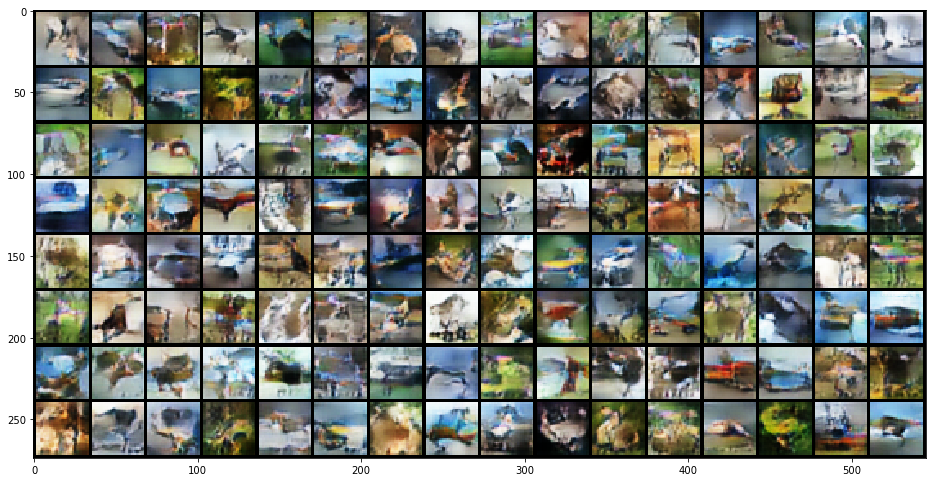

In [737]:
# samples
z, x = model(128, mode='sample')
fig, ax = plt.subplots(1,1,figsize=(16,12))
ax.imshow(make_grid(
    x.data, nrow=16, range=(-1,1), normalize=True
).cpu().numpy().transpose(1,2,0), interpolation='nearest')
pass

/home/victor/.conda/envs/torch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:135: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")


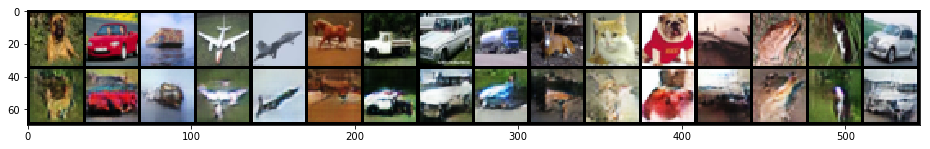

In [738]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
# training reconstructions
x = cifar[train_idxs][:16]
z, x_rec = model(x)
ax.imshow(make_grid(
    torch.cat((x, x_rec.cpu().data)), nrow=16, range=(-1,1), normalize=True
).cpu().numpy().transpose(1,2,0), interpolation='nearest')
pass

/home/victor/.conda/envs/torch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:135: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")


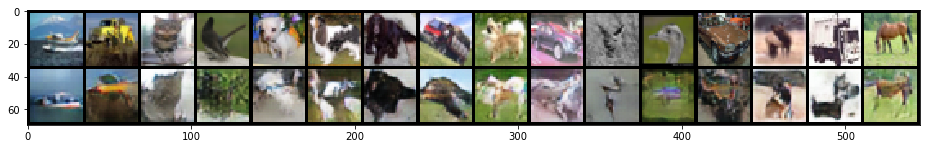

In [739]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
# test reconstructions
x = cifar_test[test_idxs][:16]
z, x_rec = model(x)
ax.imshow(make_grid(
    torch.cat((x, x_rec.cpu().data)), nrow=16, range=(-1,1), normalize=True
).cpu().numpy().transpose(1,2,0), interpolation='nearest')
pass

pairwise distances give a sense of how encoded z are distributed compared to samples from the prior:

/home/victor/.conda/envs/torch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:135: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")


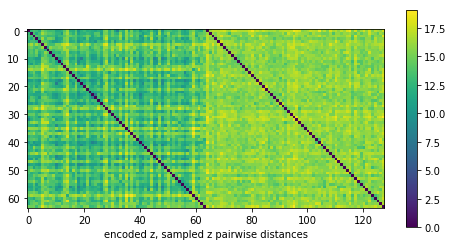

In [740]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

import scipy.spatial
x = cifar_test[test_idxs][:64]
z, x_rec = model(x)
encoded = z.data.cpu().numpy()
sampled = model.sample_prior(len(z)).data.cpu().numpy()
encoded_cdist = scipy.spatial.distance.cdist(encoded,encoded)
sampled_cdist = scipy.spatial.distance.cdist(sampled,sampled)
cax = ax.imshow(np.concatenate((encoded_cdist, sampled_cdist),1))
fig.colorbar(cax)
ax.set_xlabel('encoded z, sampled z pairwise distances')
pass